# Training Fast R-CNN-based customobject detectors

L'un des principaux inconvénients de R-CNN est qu'il faut un temps considérable pour générer des prédictions, car la génération de propositions de région pour chaque image, le redimensionnement des cultures des régions et l'extraction des caractéristiques correspondant à chaque culture (proposition de région), constituent le goulot d'étranglement.

Fast R-CNN contourne ce problème en passant l'image entière à travers le modèle pré-entraîné pour extraire les caractéristiques, puis en récupérant la région des caractéristiques qui correspondent aux propositions de région (qui sont obtenues à partir d'une recherche sélective) de l'image d'origine. Dans les sections suivantes, nous découvrirons les détails de fonctionnement de Fast R-CNN avant de l'entraîner sur notre ensemble de données personnalisé.

## Working details of Fast R-CNN

Comprenons Fast R-CNN à travers le schéma suivant:

<img src='https://miro.medium.com/max/2000/1*wgu20kFzdnRuivIwIKf_mQ.png' width=700px>
Comprenons le schéma précédent à travers les étapes suivantes

* **1** Passez l'image à travers un modèle pré-entraîné pour extraire les caractéristiques avant la couche d'aplatissement ; appelons la sortie sous forme de cartes de caractéristiques.

* **2** Extraire les propositions de région correspondant à l'image
* **3** 
Extraire la zone de carte de caractéristiques correspondant aux propositions de région (notez que lorsqu'une image est passée à travers une architecture VGG16, l'image est réduite de 32 en sortie car il y a 5 opérations de pooling effectuées. Ainsi, si une région existe avec une boîte englobante de ( 40,32,200, 240) dans l'image d'origine, la carte des caractéristiques correspondant à la boîte englobante de (5,4,25,30) correspondrait exactement à la même région)

* **4** Passez les cartes de caractéristiques correspondant aux propositions de région à travers la couche de pooling RoI (région d'intérêt) une par une afin que toutes les cartes de caractéristiques des propositions de région aient une forme similaire. Ceci est un remplacement pour le gauchissement qui a été exécuté dans la technique R-CNN.

* **5** Passer la valeur de sortie de la couche de pooling RoI via une couche entièrement connectée
* **6** Entraîner le modèle pour prédire la classe et les décalages correspondant à chaque proposition de région


Notez que la grande différence entre R-CNN et Fast R-CNN est que, dans R-CNN, nous passons les recadrages (propositions de régions redimensionnées) à travers le modèle pré-entraîné un à la fois, tandis que dans Fast R-CNN, nous recadrons la carte des caractéristiques (qui est obtenue en passant l'image entière à travers un modèle pré-entraîné) correspondant à chaque proposition de région et évitant ainsi la nécessité de passer chaque proposition de région redimensionnée à travers le modèle pré-entraîné.

Maintenant armés d'une compréhension du fonctionnement de Fast R-CNN, dans la section suivante, nous allons construire le modèle en utilisant le même ensemble de données que nous avons utilisé dans la section R-CNN.

## Implementing Fast R-CNN for object detectionon a custom dataset.

Dans cette section, nous travaillerons à la formation de notre détecteur d'objet personnalisé à l'aide de Fast R-CNN. De plus, afin de rester succinct, nous ne fournissons que le code supplémentaire ou modifié dans cette section (vous devez exécuter tout le code jusqu'à l'étape 2 de la sous-section Création des données d'entraînement de la section précédente de R-CNN) :

In [1]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from google.colab import files
files.upload() # upload kaggle.json file which you can get 
# by clicking on Create New API token in your personal account
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 42 kB 442 kB/s 
     |████████████████████████████████| 10.1 MB 8.9 MB/s 
     |████████████████████████████████| 57 kB 3.8 MB/s 
     |████████████████████████████████| 211 kB 61.7 MB/s 
     |████████████████████████████████| 56 kB 3.3 MB/s 
     |████████████████████████████████| 51 kB 5.1 MB/s 


2021-09-14 13:34:01.513 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


Saving kaggle.json to kaggle.json
kaggle.json
 99% 364M/367M [00:03<00:00, 114MB/s]
100% 367M/367M [00:03<00:00, 113MB/s]


In [2]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head())

            ImageID  Source LabelName  ...  XClick2Y  XClick3Y  XClick4Y
0  0000599864fd15b3  xclick       Bus  ...  0.512700  0.650047  0.457197
1  00006bdb1eb5cd74  xclick     Truck  ...  0.241855  0.352130  0.437343
2  00006bdb1eb5cd74  xclick     Truck  ...  0.398496  0.409774  0.295739
3  00010bf498b64bab  xclick       Bus  ...  0.493882  0.705228  0.521691
4  00013f14dd4e168f  xclick       Bus  ...  0.303940  0.999062  0.523452

[5 rows x 21 columns]


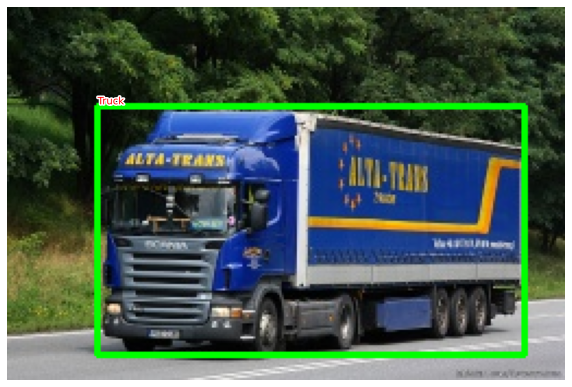

In [4]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

In [5]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

    
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [6]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [7]:

targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds

* **1** Créez une classe FRCNNDataset qui renvoie des images, des étiquettes, des vérités, des propositions de région et le delta correspondant à chaque proposition de région

In [9]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
      
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

Notez que le code précédent est très similaire à ce que nous avons appris dans la section R-CNN, le seul changement étant que nous retournons plus d'informations (rois et rixs).

La matrice rois contient des informations concernant le RoI appartenant à quelle image dans le lot. Notez que l'entrée contient plusieurs images, tandis que rois est une liste unique de boîtes. Nous ne saurions pas combien de rois appartiennent à la première image et combien appartiennent à la seconde image, et ect. C'est là que ridx entre en scène. C'est une liste d'index. Chaque entier de la liste associe le cadre de délimitation correspondant à l'image appropriée ; par exemple, si ridx est [0,0,0,1,1,2,3,3,3], alors nous savons que les trois premières boîtes englobantes appartiennent à la première image du lot, et les deux suivantes appartiennent à la seconde image dans le lot

In [11]:

n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

* **3** Définir un modèle à entraîner sur le jeu de données
  * Tout d'abord, importez la méthode RoIPool présente dans la classe torchvision.ops

In [12]:
from torchvision.ops import RoIPool

    * Définir le module réseau FRCNN

Spécifiez que RoIPool doit extraire une sortie 7 x 7. Ici, spatial_scale est le facteur par lequel les propositions (qui proviennent de l'image d'origine) doivent être réduites afin que chaque sortie ait la même forme avant de traverser la couche aplatie. Les images mesurent 224 x 224, tandis que la carte des caractéristiques mesure 14 x 14

In [13]:
class FRCNN(nn.Module):

    def __init__(self):

        super().__init__()
        rawnet = torchvision.models.vgg16_bn(pretrained=True)

        for param in rawnet.features.parameters():
            param.requires_grad = True

        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])

        

        self.roipool = RoIPool(7, spatial_scale=14/224)

        feature_dim = 512*7*7

        self.cls_score = nn.Linear(feature_dim, len(label2target))

        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    def forward(self, input, rois, ridx):

        res = input
        res = self.seq(res)

        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)

        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
        return cls_score, bbox

    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

* **4** Définir les fonctions à entraîner et valider sur un batch comme nous l'avons fait dans la section R-CNN

In [14]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 1.000	trn_loss: 1.946	trn_loc_loss: 0.860	trn_regr_loss: 0.109	trn_acc: 0.657	val_loss: 1.547	val_loc_loss: 0.663	val_regr_loss: 0.088	val_acc: 0.748	(949.76s - 3799.03s remaining)
EPOCH: 2.000	trn_loss: 1.467	trn_loc_loss: 0.647	trn_regr_loss: 0.082	trn_acc: 0.757	val_loss: 1.465	val_loc_loss: 0.613	val_regr_loss: 0.085	val_acc: 0.752	(1878.30s - 2817.45s remaining)
EPOCH: 3.000	trn_loss: 1.153	trn_loc_loss: 0.535	trn_regr_loss: 0.062	trn_acc: 0.801	val_loss: 1.438	val_loc_loss: 0.589	val_regr_loss: 0.085	val_acc: 0.759	(2812.83s - 1875.22s remaining)
EPOCH: 4.000	trn_loss: 1.005	trn_loc_loss: 0.450	trn_regr_loss: 0.056	trn_acc: 0.843	val_loss: 1.402	val_loc_loss: 0.583	val_regr_loss: 0.082	val_acc: 0.758	(3729.94s - 932.49s remaining)
EPOCH: 5.000	trn_loss: 0.874	trn_loc_loss: 0.384	trn_regr_loss: 0.049	trn_acc: 0.870	val_loss: 1.392	val_loc_loss: 0.579	val_regr_loss: 0.081	val_acc: 0.760	(4670.51s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2246.87it/s]


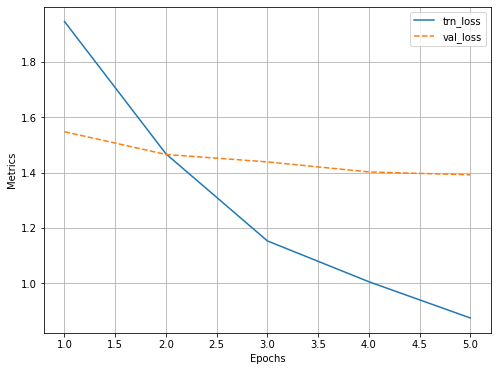

In [15]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
    log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

Définir une fonction à prédire sur des images de test

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):

    # Définissez la fonction qui prend un nom de fichier en entrée, puis lit le fichier et le redimensionne à 224 x 224
    img = cv2.resize(np.array(Image.open(filename)), (224,224))

    # Obtenez des propositions de région et convertissez-les au format (x1,y1,x2,y2) (coordonnées des pixels en haut à gauche et en bas à droite),
    # puis convertissez ces valeurs en proportion de la largeur et de la hauteur dans lesquelles elles sont présentes, proportionnellement à l'image
    candidates = extract_candidates(img)
    candidates = [(x, y, x+w, y+h) for x,y,w,h in candidates]

    #Prétraiter l'image et mettre à l'échelle la région d'intérêts (rois)
    input = preprocess_image(img/255.)[None]
    rois = [[x/224, y/224, X/224, Y/224] for x, y, X, Y in candidates]

    # Comme toutes les propositions appartiennent à la même image, rixs sera une liste de zéros (autant que le nombre de propositions)
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]

    # Propagez l'entrée et le retour sur investissement via le modèle entraîné et obtenez des confidences et des scores de classe pour chaque proposition
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)

    # Filter out the background class
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas

    # Supprimez les cadres de délimitation presque en double avec nms et obtenez des
    # indices de ces propositions dans lesquelles les modèles qui sont très fiables sont des objets
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    
    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

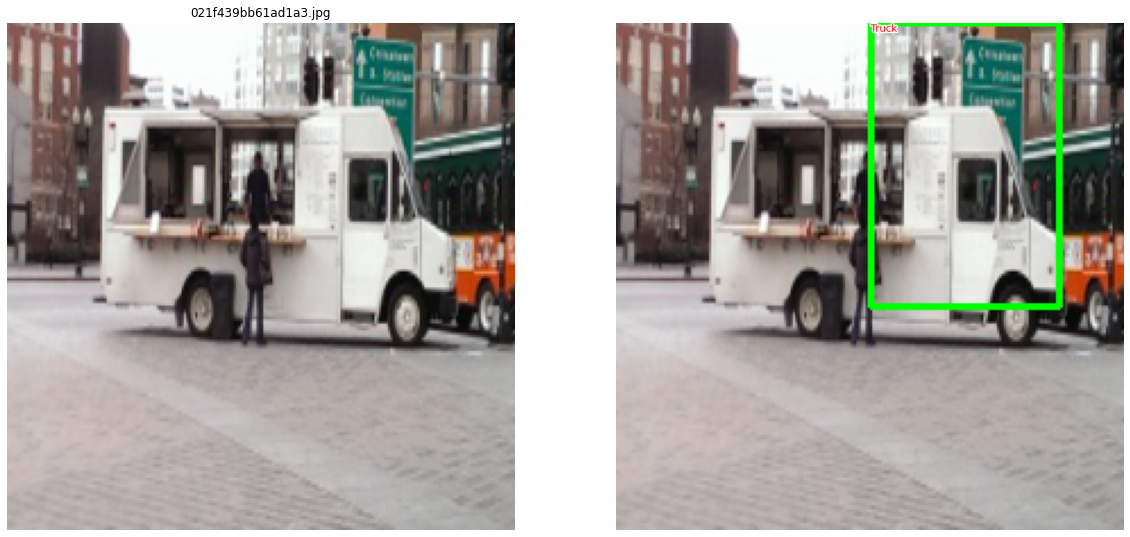

In [17]:
test_predictions(test_ds[29][-1])